# GRMDS Brace for Impact: Creating a Dashboard for Responsible Investing Using Machine Learning
This notebook contains all works done by Team **CrossEntropy** and used as one of the submission deliverables handed to the competition.

### Introduction
GRMDS provided 2 main sample datasets, `funds.csv` and `prices_per_day.csv` along with several recommended datasets for the competition. Our team focused on analyzing the 2 main datasets provided:

- `fund.csv` contains about 6,000 funds from Morningstar with 30 available features.
- `prices_per_day.csv` contains each fund prices over different timeframes ranging from 2019 to 2021.

For further information regarding the dataset given, you can access [GRMDS.org](https://grmds.org/braceImpact) 

### Importing Dataset

In [38]:
import numpy as np
import pandas as pd

In [39]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [40]:
funds = pd.read_csv('/content/drive/MyDrive/RMDS-Competition/Sample Dataset + Script/competition_data/funds.csv')
prices = pd.read_csv('/content/drive/MyDrive/RMDS-Competition/Sample Dataset + Script/competition_data/prices_per_day.csv',
                    index_col=[0],
                    parse_dates=True)

In [41]:
funds.head()

,Name,Ticker,Morningstar Sustainability Rating,Yield (%),Morningstar Category,Portfolio Sustainability Score,Portfolio Environmental Score,Portfolio Social Score,Portfolio Governance Score,Sustainable Investment by Prospectus,Sustainable Investment - ESG Fund,Sustainable Investment - Impact Fund,Sustainable Investment - Environmental Sector Fund,Animal Testing,% Alcohol,% Fossil Fuels,% Small Arms,% Thermal Coal,% Tobacco,YTD Return (%),1 Year Annualized (%),3 Years Annualized (%),5 Years Annualized (%),10 Years Annualized (%),Fund Size (Mil),Equity StyleBox,Fixed Income StyleBox,Average Market Cap (Mil),Average Credit Quality
0,AB Sustainable Intl Thematic C,AWPCX,3.0,0.00,Global Equity Large Cap,20.67,4.21,8.13,6.92,Yes,Yes,Yes,No,0,0.0,3.73,0.0,1.90,0.0,8.22,24.74,19.32,12.27,7.50,941.47,Large Growth,NaN,"32,187.09",BBB
1,AB Sustainable Thematic Credit A,STHAX,5.0,NaN,US Fixed Income,21.27,3.39,8.11,6.78,Yes,Yes,Yes,No,0,0.0,8.24,0.0,2.25,0.0,8.22,24.74,19.32,12.27,7.50,174.22,NaN,NaN,"32,187.09",BBB
2,AB Sustainable Thematic Credit Advisor,STHYX,5.0,NaN,US Fixed Income,21.27,3.39,8.11,6.78,Yes,Yes,Yes,No,0,0.0,8.24,0.0,2.25,0.0,8.22,24.74,19.32,12.27,7.50,174.22,NaN,NaN,"32,187.09",BBB
3,Aberdeen International Sust Ldrs A,BJBIX,3.0,0.54,Global Equity Large Cap,20.99,3.31,8.61,6.60,Yes,Yes,No,No,0,0.0,2.33,0.0,2.34,0.0,11.74,34.20,16.19,11.93,6.09,146.06,Large Growth,NaN,"36,331.08",BBB
4,Aberdeen International Sust Ldrs I,JIEIX,3.0,0.83,Global Equity Large Cap,20.99,3.31,8.61,6.60,Yes,Yes,No,No,0,0.0,2.33,0.0,2.34,0.0,11.99,34.56,16.49,12.20,6.36,146.06,Large Growth,NaN,"36,331.08",BBB


In [42]:
prices.head()

,stock_price,stock_name
date_time,,
2019-12-24 14:30:00,20.52,SSIAX
2019-12-26 14:30:00,20.60,SSIAX
2019-12-27 14:30:00,20.61,SSIAX
2019-12-30 14:30:00,20.53,SSIAX
2019-12-31 14:30:00,20.55,SSIAX


### Data Preparation

In [43]:
funds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6003 entries, 0 to 6002
Data columns (total 29 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   Name                                                6003 non-null   object 
 1   Ticker                                              6002 non-null   object 
 2   Morningstar Sustainability Rating                   5993 non-null   float64
 3   Yield (%)                                           5910 non-null   float64
 4   Morningstar Category                                6001 non-null   object 
 5   Portfolio Sustainability Score                      5993 non-null   float64
 6   Portfolio Environmental Score                       5993 non-null   float64
 7   Portfolio Social Score                              5993 non-null   float64
 8   Portfolio Governance Score                          5991 non-null   float64
 9

For data cleaning process, we will convert `Fund Size (Mil)` and `Average Market Cap (Mil)` columns into float data type and we will ignore columns `Equity Stylebox` and `Fixed Income Stylebox`, and converting binary columns of `Sustainable Investment`s into numeric categorical data type.

In [44]:
cols = [col for col in funds.columns if col not in ['Equity StyleBox','Fixed Income StyleBox']]
funds.dropna(axis=0, subset=cols, inplace=True)
funds.reset_index(drop=True, inplace=True)
funds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5859 entries, 0 to 5858
Data columns (total 29 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   Name                                                5859 non-null   object 
 1   Ticker                                              5859 non-null   object 
 2   Morningstar Sustainability Rating                   5859 non-null   float64
 3   Yield (%)                                           5859 non-null   float64
 4   Morningstar Category                                5859 non-null   object 
 5   Portfolio Sustainability Score                      5859 non-null   float64
 6   Portfolio Environmental Score                       5859 non-null   float64
 7   Portfolio Social Score                              5859 non-null   float64
 8   Portfolio Governance Score                          5859 non-null   float64
 9

In [45]:
clean_float = lambda x:str(x).replace(',','')

In [46]:
funds['Fund Size (Mil)'] = funds['Fund Size (Mil)'].apply(clean_float).astype('float64')
funds['Average Market Cap (Mil)'] = funds['Average Market Cap (Mil)'].apply(clean_float).astype('float64')

In [47]:
sus_inv = ['Sustainable Investment by Prospectus',
           'Sustainable Investment - ESG Fund',
           'Sustainable Investment - Impact Fund',
           'Sustainable Investment - Environmental Sector Fund']

for col in sus_inv:
  funds[col] = funds[col].map({'Yes':1, 'No':0})

In [48]:
funds.describe()

,Morningstar Sustainability Rating,Yield (%),Portfolio Sustainability Score,Portfolio Environmental Score,Portfolio Social Score,Portfolio Governance Score,Sustainable Investment by Prospectus,Sustainable Investment - ESG Fund,Sustainable Investment - Impact Fund,Sustainable Investment - Environmental Sector Fund,Animal Testing,% Alcohol,% Fossil Fuels,% Small Arms,% Thermal Coal,% Tobacco,YTD Return (%),1 Year Annualized (%),3 Years Annualized (%),5 Years Annualized (%),10 Years Annualized (%),Fund Size (Mil),Average Market Cap (Mil)
count,5859.000000,5859.000000,5859.000000,5859.000000,5859.000000,5859.000000,5859.000000,5859.000000,5859.000000,5859.000000,5859.000000,5859.000000,5859.000000,5859.000000,5859.000000,5859.000000,5859.000000,5859.000000,5859.000000,5859.000000,5859.000000,5859.000000,5859.000000
mean,3.507254,0.957605,22.341441,3.715907,8.562458,6.489626,0.123059,0.119816,0.056836,0.005803,0.014508,0.719549,5.915730,0.620425,1.067609,0.467443,13.017896,26.158078,15.740975,13.020848,10.964673,5697.872400,80319.764485
std,0.713050,1.268312,2.792331,1.516466,2.277421,1.589643,0.328532,0.324774,0.231548,0.075963,0.119581,1.405485,9.893306,0.967139,2.752095,0.925361,10.021440,16.773055,7.249178,6.370510,4.935264,18474.553968,76826.572938
min,1.000000,0.000000,10.380000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-22.930000,-20.120000,-11.170000,-9.340000,-5.860000,0.200000,3.970000
25%,3.000000,0.020000,20.770000,2.965000,8.175000,6.320000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.070000,0.000000,0.000000,0.000000,6.455000,13.955000,11.115000,9.085000,7.630000,234.980000,23507.410000
50%,3.000000,0.670000,22.260000,3.750000,9.140000,7.010000,0.000000,0.000000,0.000000,0.000000,0.000000,0.070000,4.820000,0.170000,0.450000,0.000000,13.370000,26.660000,15.180000,12.690000,11.360000,923.680000,60665.720000
75%,4.000000,1.380000,23.530000,4.210000,9.870000,7.330000,0.000000,0.000000,0.000000,0.000000,0.000000,0.870000,7.010000,0.880000,1.310000,0.610000,20.340000,38.200000,20.020000,16.865000,14.570000,3649.340000,100390.170000
max,5.000000,34.080000,35.200000,14.040000,14.530000,11.200000,1.000000,1.000000,1.000000,1.000000,1.000000,13.450000,100.690000,7.910000,63.910000,12.250000,60.970000,113.530000,49.750000,36.510000,25.530000,379808.550000,531740.190000


In [49]:
prices.isna().sum()

stock_price    1
stock_name     0
dtype: int64

In [50]:
prices.dropna(inplace=True)
prices.isna().sum()

stock_price    0
stock_name     0
dtype: int64

The `prices.csv` data is in the form of long data. We are going to convert it to wide data using pivot table based on the `stock_name` column.

In [51]:
prices_wide = pd.pivot_table(prices, index = 'date_time', columns='stock_name', values='stock_price', aggfunc='mean', fill_value = np.nan)
prices_wide = pd.DataFrame(prices_wide.to_records())
prices_wide.set_index('date_time', inplace=True)
prices_wide.head()

,AAAAX,AAAIX,AAANX,AAAPX,AAAQX,AAARX,AAASX,AAAUX,AAAVX,AAAWX,AAAZX,AACCX,AACDX,AACFX,AACGX,AACRX,AADGX,AADIX,AADTX,AADYX,AAEMX,AAESX,AAETX,AAFTX,AAGTX,AAHTX,AAIEX,AAIPX,AAISX,AALTX,AAMTX,AANTX,AASOX,AATIX,AATSX,AAWEX,AAWVX,ABALX,ABASX,ABCAX,...,WPVAX,WRAAX,WRAIX,WSBFX,WSCGX,WSCYX,WSEFX,WSGAX,WSGRX,WSMGX,WSTAX,WSTRX,WSTYX,WTDLX,WTDMX,WTDOX,WTDPX,WTDQX,WTDRX,WTDTX,WTDUX,WTDVX,WTDZX,WTLVX,WTRCX,WTRIX,WTSZX,WVAIX,WVALX,WVCCX,WWHCX,WWIDX,YACKX,YAFFX,YAFIX,YCGEX,ZDIIX,ZDIVX,ZGEIX,ZSRIX
date_time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-12-24 14:30:00,10.54,7.24,12.87,10.48,10.61,7.38,10.45,7.21,10.45,10.54,10.45,5.38,5.47,24.19,5.48,5.46,13.74,15.83,14.56,15.72,10.02,15.83,15.73,16.42,16.88,17.19,18.37,18.23,18.71,16.87,21.07,13.98,28.82,15.77,16.15,7.43,11.60,28.47,19.90,18.61,...,26.45,11.69,11.83,20.71,55.71,22.06,26.41,17.05,16.57,29.80,71.68,69.03,76.64,10.74,10.63,10.80,10.82,10.74,10.61,10.79,10.80,10.75,10.84,13.72,11.72,13.22,10.86,47.46,46.78,28.13,NaN,13.79,20.40,18.16,18.10,21.35,22.09,22.11,NaN,10.06
2019-12-26 14:30:00,10.58,7.26,12.94,10.52,10.65,7.40,10.49,7.24,10.49,10.58,10.49,5.39,5.48,24.31,5.49,5.47,13.76,15.88,14.60,15.77,10.09,15.87,15.77,16.47,16.93,17.24,18.40,18.26,18.75,16.93,21.14,14.03,28.83,15.78,16.12,7.44,11.62,28.56,19.91,18.68,...,26.55,11.69,11.82,20.77,55.67,22.08,26.52,17.07,16.59,29.83,72.26,69.60,77.27,10.76,10.65,10.82,10.84,10.76,10.64,10.81,10.83,10.78,10.86,13.75,11.78,13.22,10.88,47.70,47.02,28.24,NaN,13.83,20.47,18.23,18.17,21.44,22.14,22.15,NaN,NaN
2019-12-27 14:30:00,10.61,7.27,12.94,10.55,10.68,7.41,10.52,7.24,10.52,10.61,10.52,5.39,5.49,24.36,5.50,5.47,13.75,15.89,14.62,15.78,10.09,15.89,15.80,16.49,16.95,17.27,18.50,18.35,18.84,16.95,21.16,14.05,28.74,15.71,16.05,7.41,11.60,28.59,19.86,18.70,...,26.65,11.72,11.86,20.79,55.47,21.96,26.53,16.97,16.50,29.72,72.12,69.46,77.12,10.60,10.54,10.63,10.64,10.60,10.54,10.63,10.63,10.60,10.67,13.74,11.79,13.24,10.67,47.73,47.05,28.34,NaN,13.82,20.50,18.26,18.20,21.48,22.12,22.13,NaN,10.06
2019-12-30 14:30:00,10.58,7.24,12.85,10.52,10.66,7.37,10.49,7.21,10.50,10.58,10.50,5.38,5.48,24.30,5.48,5.46,13.74,15.83,14.05,15.72,10.06,15.83,15.13,15.74,16.16,16.47,18.38,18.23,18.71,16.18,20.25,13.52,28.51,15.68,16.02,7.35,11.55,28.47,19.83,18.62,...,26.52,11.69,11.82,20.73,55.19,21.82,26.43,16.87,16.40,29.64,71.44,68.80,76.38,10.56,10.50,10.59,10.60,10.56,10.50,10.59,10.59,10.56,10.63,13.69,11.71,13.24,10.64,47.42,46.75,28.20,NaN,13.76,20.41,18.18,18.12,21.34,22.02,22.04,NaN,10.04
2019-12-31 14:30:00,10.62,7.25,12.89,10.56,10.70,NaN,10.53,7.22,10.54,10.62,10.54,5.38,5.48,24.37,5.49,5.46,13.77,15.85,14.07,15.74,10.09,15.85,15.16,15.77,16.20,16.51,18.46,18.31,18.80,16.22,20.29,13.56,28.69,15.73,16.06,7.39,11.57,28.50,19.91,18.64,...,26.56,11.71,11.85,20.76,55.43,21.88,26.47,16.91,16.44,29.70,71.57,68.92,76.53,10.57,10.51,10.60,10.61,10.57,10.51,10.60,10.60,10.57,10.64,13.72,11.73,13.21,10.65,47.56,46.88,28.24,NaN,13.79,20.48,18.25,18.19,21.37,22.09,22.10,NaN,10.04


Since this is a dataset for stocks, missing values might represent the stock market not open during that timeframe, therefore we are going to use last known price for filling up missing values.

Additionally, for stocks that does not have data until certain dates (as in it emerges at later year), we will use the first price when it emerges at the market.

In [52]:
prices_wide.fillna(method='ffill', inplace=True)
prices_wide.fillna(method='bfill', inplace=True)
prices_wide.isna().sum().sum()

0

In [53]:
print(len(funds))
print(len(prices_wide.columns))

5859
5986


There is a difference between the amount of data by funds present between both datasets. Therefore, we will only select funds that are present in both datasets



In [54]:
fund_from_funds = set(funds['Ticker'])
fund_from_prices = set(prices_wide.columns)

clean_fund = list(fund_from_funds.intersection(fund_from_prices))
len(clean_fund)

5840

In [55]:
funds = funds[funds['Ticker'].isin(clean_fund)]
print(len(funds))

prices = prices[prices['stock_name'].isin(clean_fund)]
print(prices['stock_name'].nunique())

prices_wide = prices_wide[clean_fund]
print(len(prices_wide.columns))

5840
5840
5840


### Exploratory Data Analysis

In [56]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

In [57]:
funds.groupby('Morningstar Category').sum().sort_values('Average Market Cap (Mil)', ascending=False).head(5).index

Index(['US Equity Large Cap Growth', 'US Equity Large Cap Blend',
       'Global Equity Large Cap', 'Moderate Allocation', 'Target Date'],
      dtype='object', name='Morningstar Category')

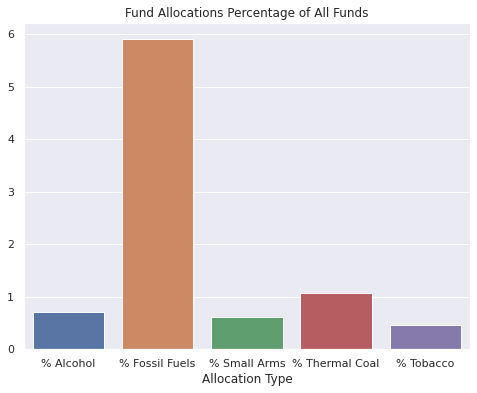

In [92]:
fundallocs = ['% Alcohol','% Fossil Fuels','% Small Arms','% Thermal Coal','% Tobacco']

fig, ax = plt.subplots(figsize=(8,6))
sns.barplot(x=[1,2,3,4,5],
            y=funds[fundallocs].mean(),
            ax=ax)
ax.set_xticklabels(fundallocs)
ax.set_title('Fund Allocations Percentage of All Funds')
ax.set_xlabel('Allocation Type')
plt.show()

Most Funds seems to allocate their fundings for fossil fuels

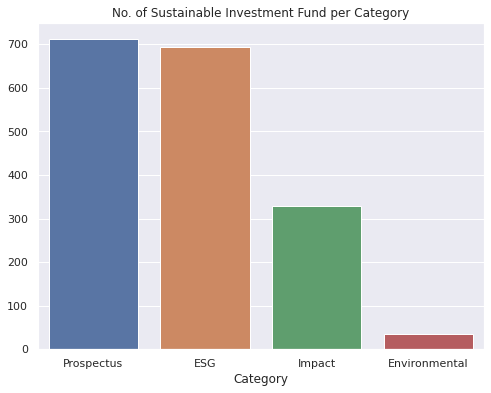

In [94]:
fig, ax = plt.subplots(figsize=(8,6))
sns.barplot(x=[1,2,3,4],
            y=funds[sus_inv].sum(),
            ax=ax)
ax.set_xticklabels(['Prospectus','ESG','Impact','Environmental'])
ax.set_title('No. of Sustainable Investment Fund per Category')
ax.set_xlabel('Category')
plt.show()

As per total fund data of 5840, sustainable investment per category seems to have a very low amount.

In [60]:
returns = ['YTD Return (%)',
           '1 Year Annualized (%)',
           '3 Years Annualized (%)',
           '5 Years Annualized (%)',
           '10 Years Annualized (%)']

returns_creds = funds.groupby('Average Credit Quality').mean()[returns]

In [61]:
returns_creds

,YTD Return (%),1 Year Annualized (%),3 Years Annualized (%),5 Years Annualized (%),10 Years Annualized (%)
Average Credit Quality,,,,,
A,11.768031,23.682154,15.629431,13.107193,11.341848
AA,12.366503,22.853561,15.512687,12.372687,10.056844
AAA,14.743689,28.862951,15.722520,12.923648,10.504836
B,10.776271,24.388362,14.589661,12.164294,9.541864
BB,13.461165,27.415976,15.791219,12.906505,10.872294
BBB,13.624780,27.426983,15.982283,13.377228,11.284853


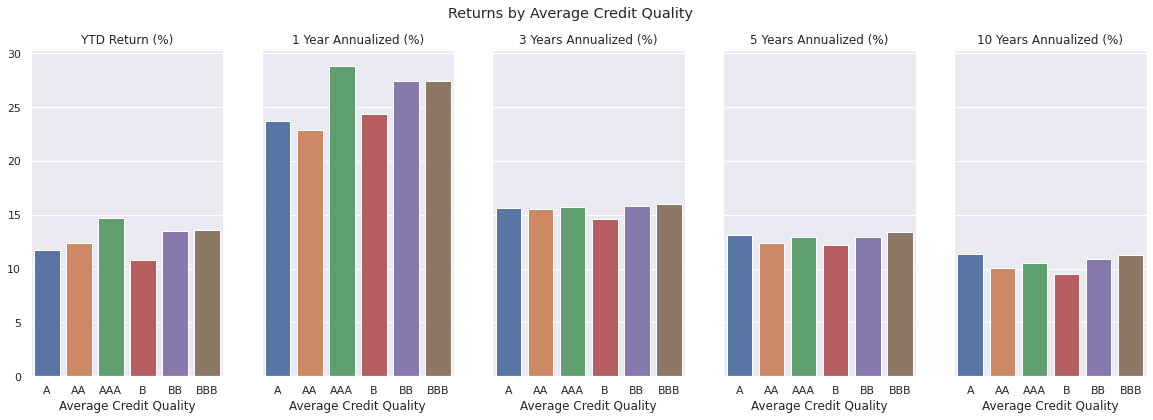

In [89]:
fig, ax = plt.subplots(1,5, figsize=(20,6), sharey=True)

for i,col in enumerate(returns_creds.columns):
  sns.barplot(x=returns_creds.index, 
              y=returns_creds[col], 
              ax=ax[i])
  ax[i].set_title(col)
  ax[i].set_ylabel(None)

fig.suptitle('Returns by Average Credit Quality')
plt.show()

Funds with Average Credit Quality of A have better sustainability in keeping its return percentage over different timeframes as compared to other credit qualities.

In [62]:
prices.reset_index(inplace=True)
prices_cred = prices.merge(funds[['Average Credit Quality','Ticker']], left_on='stock_name', right_on='Ticker')
prices_cred.drop('stock_name', axis=1, inplace=True)
prices_cred.head()

,date_time,stock_price,Average Credit Quality,Ticker
0,2019-12-24 14:30:00,20.52,A,SSIAX
1,2019-12-26 14:30:00,20.60,A,SSIAX
2,2019-12-27 14:30:00,20.61,A,SSIAX
3,2019-12-30 14:30:00,20.53,A,SSIAX
4,2019-12-31 14:30:00,20.55,A,SSIAX


In [71]:
prices_cred_wide = pd.pivot_table(data=prices_cred, values='stock_price', index='date_time', columns='Average Credit Quality', fill_value=np.nan)
prices_cred_wide.head()

Average Credit Quality,A,AA,AAA,B,BB,BBB
date_time,,,,,,
2019-12-24 14:30:00,23.258338,24.127131,19.504086,22.475119,20.204894,23.836987
2019-12-26 14:30:00,23.454494,24.025611,19.824890,22.547563,20.506360,24.089703
2019-12-27 14:30:00,23.397076,24.376374,19.644043,22.975247,20.349352,23.996850
2019-12-30 14:30:00,23.517771,24.245035,19.724910,23.305641,20.325470,23.922820
2019-12-31 14:30:00,23.338679,24.032584,19.627758,22.856626,20.151223,23.936650
...,...,...,...,...,...,...
2021-12-17 14:30:00,28.113616,29.873962,23.290630,25.341497,24.846386,29.484204
2021-12-20 14:30:00,27.211674,29.134604,22.656255,24.827838,24.223498,28.390409
2021-12-21 14:30:00,27.734733,29.637678,23.204560,25.060000,24.684800,28.819976


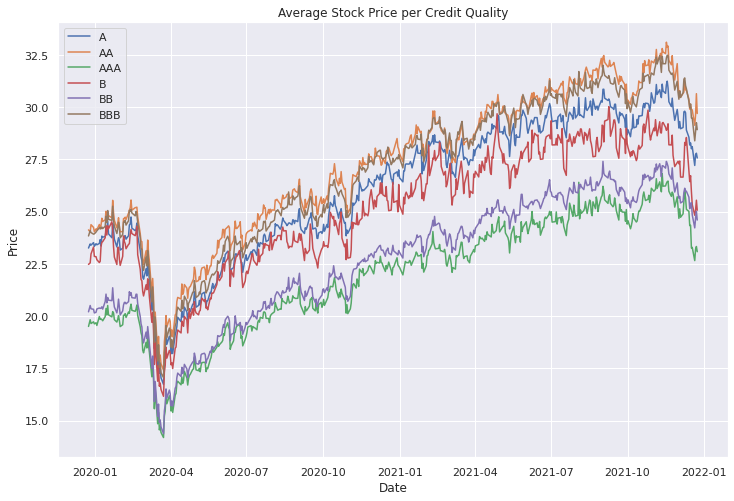

In [75]:
fig, ax = plt.subplots(figsize=(12,8))
plt.plot(prices_cred_wide)
plt.title('Average Stock Price per Credit Quality')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend(prices_cred_wide.columns)
plt.show()

Funds having highest stock price overtime are funds with Average Credit Quality of AA, while the lowest ones are funds with Average Credit Quality of AAA

In [63]:
prices_cat = prices.merge(funds[['Morningstar Category','Ticker']], left_on='stock_name', right_on='Ticker')
prices_cat.drop('stock_name', axis=1, inplace=True)
prices_cat.head()

,date_time,stock_price,Morningstar Category,Ticker
0,2019-12-24 14:30:00,20.52,Moderate Allocation,SSIAX
1,2019-12-26 14:30:00,20.60,Moderate Allocation,SSIAX
2,2019-12-27 14:30:00,20.61,Moderate Allocation,SSIAX
3,2019-12-30 14:30:00,20.53,Moderate Allocation,SSIAX
4,2019-12-31 14:30:00,20.55,Moderate Allocation,SSIAX


In [64]:
prices_pivot = pd.pivot_table(data=prices_cat, values='stock_price', index='date_time', columns='Morningstar Category', fill_value=np.nan)
prices_pivot

Morningstar Category,Aggressive Allocation,Alternative Miscellaneous,Asia Equity,Asia ex-Japan Equity,Cautious Allocation,Commodities Broad Basket,Communications Sector Equity,Consumer Goods & Services Sector Equity,Emerging Markets Fixed Income,Energy Sector Equity,Equity Miscellaneous,Europe Emerging Markets Equity,Europe Equity Large Cap,Europe Equity Mid/Small Cap,Financials Sector Equity,Fixed Income Miscellaneous,Flexible Allocation,Global Emerging Markets Equity,Global Equity Large Cap,Global Equity Mid/Small Cap,Global Fixed Income,Global Macro,Greater China Equity,Healthcare Sector Equity,India Equity,Industrials Sector Equity,Infrastructure Sector Equity,Japan Equity,Latin America Equity,Long/Short Equity,Market Neutral,Moderate Allocation,Multialternative,Natural Resources Sector Equity,Options Trading,Precious Metals Sector Equity,Real Estate Sector Equity,Target Date,Technology Sector Equity,US Equity Large Cap Blend,US Equity Large Cap Growth,US Equity Large Cap Value,US Equity Mid Cap,US Equity Small Cap,US Fixed Income,US Municipal Fixed Income,Utilities Sector Equity
date_time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-12-24 14:30:00,16.863661,10.125333,23.000000,21.520588,12.240743,5.546000,21.645000,32.847,9.404875,12.440233,13.310278,15.186,27.447500,22.360000,37.085000,11.615000,31.046567,21.161466,21.625582,19.120567,10.517759,13.433793,29.196000,41.093542,24.761667,61.205,15.358182,21.821,43.41000,13.640000,12.993448,17.585042,13.264324,37.432143,16.241379,20.207391,20.109000,14.470045,42.094675,36.353170,33.414661,24.137101,28.109067,24.819049,12.034810,11.697500,20.609167
2019-12-26 14:30:00,16.846875,10.265714,23.080000,21.579412,12.362469,5.582000,25.326667,33.106,9.701270,12.513721,13.337778,15.232,27.494375,22.400000,37.221667,11.442727,31.108955,21.512044,21.409972,19.509343,10.570364,13.678077,29.387143,40.969556,24.646667,61.370,15.405152,21.837,43.94875,13.663867,13.082857,17.687521,13.430000,37.557143,16.840000,20.416087,20.183000,14.517902,42.387922,36.539860,33.630679,24.219477,28.263318,24.801634,12.216512,11.870588,20.658333
2019-12-27 14:30:00,16.612545,10.163333,23.163333,21.663529,12.331520,7.485000,21.772500,33.104,9.777706,12.341220,13.488857,15.296,27.653750,22.646667,37.203333,11.086000,31.165672,21.295369,21.730250,19.137163,10.583818,13.472069,29.460286,41.607609,24.893333,61.280,15.459697,21.839,43.87625,13.707162,12.937143,17.597324,13.192973,38.910769,16.512308,20.338261,20.257071,14.429955,42.327792,36.338933,33.542127,24.182020,28.090112,24.702511,12.134133,11.963750,20.675000
2019-12-30 14:30:00,16.355491,10.084000,23.103333,21.624706,12.202791,5.580000,21.595000,32.922,9.818620,12.274651,13.305556,15.216,27.487500,22.486667,37.033333,11.166471,31.747812,21.218736,21.566233,19.030213,10.642115,13.461724,29.430571,40.714167,24.876667,60.920,15.400303,21.635,43.72375,13.602400,12.932500,17.470282,13.230000,37.260714,16.466154,20.701304,20.266714,13.984129,41.991429,36.095568,33.290995,24.069349,28.009821,24.692252,12.278000,10.845000,20.670833
2019-12-31 14:30:00,16.416502,10.066667,23.156667,21.654118,12.093333,5.522000,21.650000,32.981,9.420443,12.375581,12.883333,15.228,28.663333,22.546667,37.110000,11.832632,31.521692,21.218389,21.728443,19.516370,10.544211,13.438966,29.495714,40.792083,24.785000,61.035,15.451515,21.821,43.72125,13.624000,12.944483,17.469690,13.104865,37.492143,16.960741,20.704348,20.365714,13.987494,42.119351,36.183434,33.360226,24.091311,28.041853,24.736705,12.145419,11.704500,20.770833
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-17 14:30:00,20.156611,10.581333,25.470000,22.330588,13.300601,22.418333,27.217500,48.489,9.129589,11.050714,15.535135,17.262,34.674375,31.356667,48.351667,11.901667,35.374493,24.375207,26.442174,23.724755,10.319000,15.046000,31.486111,45.708125,31.693333,68.835,15.62

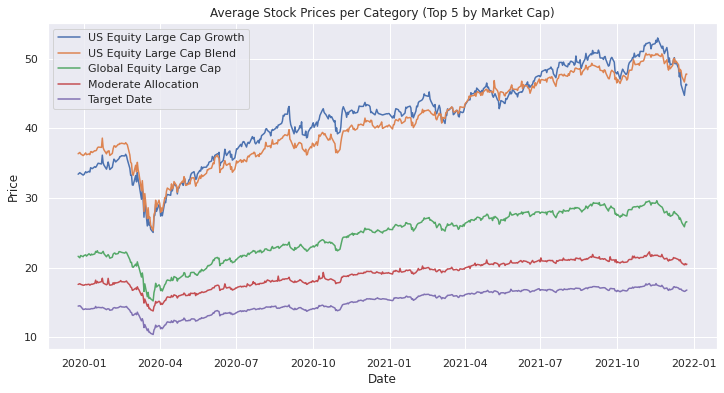

In [65]:
fig, ax = plt.subplots(figsize=(12,6))
cols = ['US Equity Large Cap Growth', 'US Equity Large Cap Blend','Global Equity Large Cap', 'Moderate Allocation', 'Target Date']
plt.plot(prices_pivot[cols])
plt.title('Average Stock Prices per Category (Top 5 by Market Cap)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend(cols)
plt.show()

There seems to be a negative fluctuation of price in the early 2020s. We can see it further with the prices dataset.

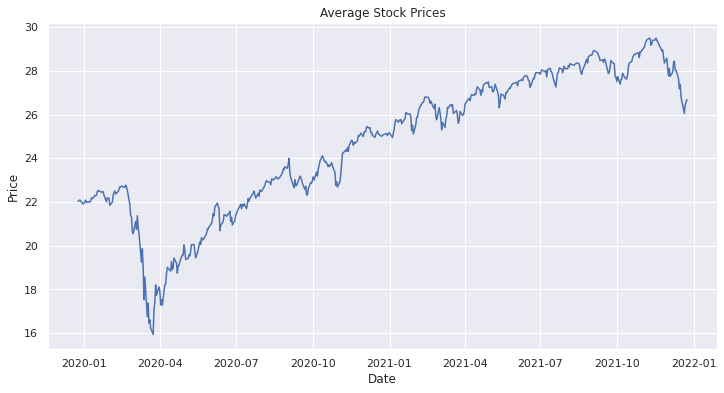

In [66]:
fig, ax = plt.subplots(figsize=(12,6))
plt.plot(prices_wide.mean(axis=1))
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Average Stock Prices')
plt.show()

There is indeed a major decline during early 2020s, which makes sense due to COVID-19 pandemic. Afterwards, funds are starting to enter restoration phase over 2 years.

### Exporting Cleaned Datasets

Exported datasets will be further used to create the dashboard externally

In [ ]:
funds.to_csv('/content/funds.csv', index=False, header=True)
prices.to_csv('/content/prices_per_day.csv', index=False, header=True)
prices_wide.to_csv('/content/prices_wide.csv', header=True)
prices_pivot.to_csv('/content/prices_per_cats.csv', header=True)